In [82]:
import scprep
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import graphtools as gt

#from gprofiler import GProfiler
import os
import tasklogger
import pickle
import re # regexp
import itertools

import sklearn.cluster
import magic
import phenograph
import louvain
import umap
import phate
from sklearn.manifold import TSNE

import gseapy

import anndata, scanpy

plt.rcParams['figure.figsize']=(6,6) #rescale figures

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [103]:
# LIST OF INTERESTING GENES

coremarkers = ['^SOX2($| )','^TBXT($| )','^SOX17($| )','^ISL1($| )'] 

epiblast = ['^SOX2(($| )| )','^NANOG($| )','^POU5F1($| )','^KLF4($| )','^OTX2($| )','^ESRG($| )','^DPPA4($| )']
mesoderm = ['^GSC($| )','^TBXT($| )','^MIXL1($| )','^EOMES($| )','^TBX6($| )','^MESP1($| )','^GATA6($| )','^GATA4($| )','^MSGN1($| )','^PDGFRA($| )','^EPHA4($| )','^ZIC3($| )'] # ,'EPHA4','ZIC3' Zhou..Lanner..Chien embryonic mesoderm
exmeso = ['^PODXL($| )','^ETS1($| )'] #Zhou..Lanner...
endoderm = ['OTX2($| )','PRDM1($| )','SOX17($| )','FOXA2($| )','HHEX($| )','LHX1($| )','TTR($| )','GATA4($| )','KIT($| )','CXCR4($| )']
ectoderm = ['^SOX1($| )', '^SOX2($| )', '^SOX3($| )','NES']
TE = ['CGA($| )','XAGE3($| )','PGF($| )','WNT3A($| )']
amnion = ['ISL1($| )','BMP4($| )','GABRP($| )','HEY1($| )','LYPD1($| )','WNT6($| )']#,'WFDC2($| )','ANXA3($| )','CDO1($| )'] #Zhou..Lanner...
exMC = ['VIM($| )','COL3A1','HGF','COL6A2','HAND2($| )','COL1A1','POSTN']
extraembryonic = ['CDX2($| )', 'GATA2($| )','GATA3($| )','HAND1($| )','TBX3($| )','TFAP2A($| )','DLX5($| )','KRT18($| )','KRT7($| )','TP63($| )'] + TE + amnion + exmeso + exMC;

PGC = ['PRDM1($| )','SOX17($| )','TFAP2C($| )','NANOG($| )','ALPP($| )','DPPA4($| )','NANOS3($| )','LAMA4($| )','KLF4($| )','KIT($| )','CXCR4($| )','DDX4($| )','DAZL($| )','DPPA3($| )'] # DDX4=VASA, DPPA3=stella
endothelium = ['PECAM1($|c )', 'MEF2C($| )']
blood = ['RUNX1($| )','GATA1($| )','HBE1($| )']
heart = ['NKX2-5($| )','MESP1($| )','TBX1($| )','TBX5($| )','ISL1($| )','TNNT2($| )']
lung = ['NKX2-1($| )']
organs = endothelium + blood + heart + lung

HOX = ['HOX[ABCD][1-9]+($| )'];

germmarkers =  list(np.unique(epiblast + mesoderm + endoderm + ectoderm + extraembryonic + PGC))
allmarkers = list(np.unique(germmarkers + organs + HOX))

coreligands = ['DKK[1-9]($| )',"LEFTY[1-2]($| )","NODAL($| )","WNT3($| )","WNT3A($| )","WNT6($| )","WNT5A($| )","WNT5B($| )","BMP2($| )","BMP4($| )","BMP7($| )","^CER1($| )","NOG($| )",'FGF2($| )','FGF4($| )','FGF8($| )','FGF17($| )']
TGFbtransduction = ['SMAD[1-9]($| )','^ACVR[1-2][ABC]*($| )','BMPR[1-2][ABC]*($| )','TGFBR','TDGF1($| )']
wnt = ['WNT[1-9]+[AB]*($| )','RSPO[1-9]($| )','FZD[1-9]*($| )','^DVL']
othersignaling = ['^EGF($| )','^EGFR($| )']

FGFR = ['^FGFR[1-4]($| )']
extracell_FGFact = ['^KL($| )','^GLG1($| )','^FLRT($| )', '^KAL1($| )'] # klotho, cfr, flrt, anosmin-1
extracell_FGFinh = ['^FGFRL1','^IL17RD'] # FGFRL1, SEF
intracell_ERKinh = ['^SPRY[1-4]($| )','^DUSP[1-9]($| )','^DUSP10($| )','^DUSP14($| )','^DUSP26($| )','^PEBP1($| )']
intracell_ERKact = ['^MAP2K[1-2]($| )','^MAPK3($| )','^MAPK1($| )','^ARAF($| )','^BRAF($| )','^RAF1($| )'] #K3 = ERK1, #K1 = ERK2, MEK1/2 are phosporylated by RAS
HSPG_synthesis = ['^EXT1($| )','^EXT2($| )','^UGDH($| )'] # EXT catalyze HS side chain elongation, UGDH : Garcia-Garcia & Anderson, makes side chains
HSPG = ['^HSPG2($| )', '^AGRIN($| )', '^SDC[1-4]($| )', '^GPC[1-9]($| )'] # HSPG2: perlecan (secreted), agrin=secreted, syndecan=transmembrane, glypican (GPI-anchored)
HSPG_desulf = ['^SULF'] # 6-O sulfatases - inhibit FGF
HSPG_shedding = ['^HPSE($| )', '^HTRA1($| )'] # heparanase
HSPG_sulfotransferase = ['^HS6ST','^HS2ST', '^HS3ST', '^NDST'] 

FGF_inhibition = HSPG_desulf + extracell_FGFinh + intracell_ERKinh
FGF_activation = FGFR + extracell_FGFact + HSPG_synthesis + HSPG + HSPG_shedding + HSPG_sulfotransferase + intracell_ERKact

FGF_modulation = FGF_inhibition + FGF_activation

allsignaling = coreligands + TGFbtransduction + FGF_modulation + wnt + othersignaling;

EMT = ['^CDH[1-2]($| )','VIM($| )','EPCAM($| )','SNAI[1-2]($| )','^PAI[1-3]($| )']

allgenes = list(np.unique(allmarkers + allsignaling + EMT))

In [84]:
# Early marker genes dict:
marker_genes = dict()
marker_genes['Epiblast'] = epiblast;
marker_genes['Mesoderm'] = mesoderm;
marker_genes['Endoderm'] = endoderm;
marker_genes['TE'] = TE;
marker_genes['Amnion'] = amnion;
marker_genes['ExtraEm'] = extraembryonic;
marker_genes['ExMC'] = exMC;
marker_genes['PGC'] = PGC

QC numbers:

Total 1.16 x 106/mL

Live 80% 9.21 x 105/mL

Dead 20% 2.35 x 105/mL

In [85]:
def select_genes(data, genelist) : 

    collist = [];
    genesymbolslist = [];
    
    for g in genelist :
        sublist = [col for col in data.columns if re.match(g, col)]
        
        splitnames = [s.split(' ') for s in sublist]
        genesymbols = [g[0] for g in splitnames];
        
        genesymbolslist = genesymbolslist + genesymbols;
        collist = collist + sublist;

    [names, index] = np.unique(collist,return_index=True)
    collist = [collist[i] for i in index]
    genesymbolslist = [genesymbolslist[i] for i in index]
        
    return collist, genesymbolslist

def get_genes_expression(data, genelist) :
    
    collist, __ = select_genes(data, genelist)  
    expr = data[collist] 
    expr = np.sum(expr,axis=1) 
    return expr

def plot_genes(visualization, data, genelist) :

    collist, genelist = select_genes(data, genelist)
    
    nrows = int(np.ceil(len(collist)/5));
    if nrows > 1 :
        fig, axes = plt.subplots(nrows, 5, figsize=(20, nrows*4))
    else :
        fig, axes = plt.subplots(nrows, len(collist), figsize=(len(collist)*4, nrows*4))

    vis_pd = pd.DataFrame(visualization, index=data.index)
    
    for i in range(0,len(collist)) :
        rowi = int(np.floor(i/5))
        coli = i%5
        
        expression = scprep.select.select_cols(data, exact_word=genelist[i])
        sort_index = expression.sort_values().index
    
        figax = axes[rowi,coli] if nrows > 1 else axes[coli]
        scprep.plot.scatter2d(vis_pd.loc[sort_index], c=expression.loc[sort_index], title=genelist[i],
                      ticks=False, ax=figax, label_prefix='PHATE')
        
        plt.tight_layout()

In [86]:
len(allgenes) # this is just the length of the list of regular expressions

146

In [87]:
# data location
scseqDir = '/Users/idse/data_tmp/scRNAseq/'
dataDir = scseqDir + '201008_42hMP/Sample_1810-KJ-1_TTGCCCGT-AATCTCAC/outs/'
countMatrixFile = dataDir + 'filtered_feature_bc_matrix.h5';

In [88]:
# load data in sparse format
with tasklogger.log_task("sparse"):
    data = scprep.io.load_10X_HDF5(countMatrixFile,
                                    sparse=True, gene_labels='both')

# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data)) / 1024**2))

Calculating sparse...
Calculated sparse in 6.16 seconds.
Size: 531.6MB


In [89]:
data.shape # data.columns, data.index, data.head(10)

(12948, 36601)

In [90]:
collist, symbolslist = select_genes(data, allgenes);
len(collist)

258

## Quality Control

(0.0, 100000.0)

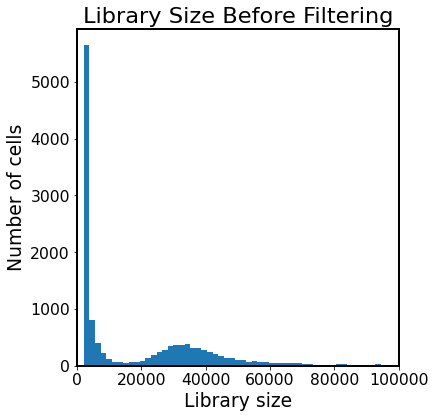

In [91]:
scprep.plot.plot_library_size(data, log=False, title='Library Size Before Filtering');
plt.xlim([0, 100000])

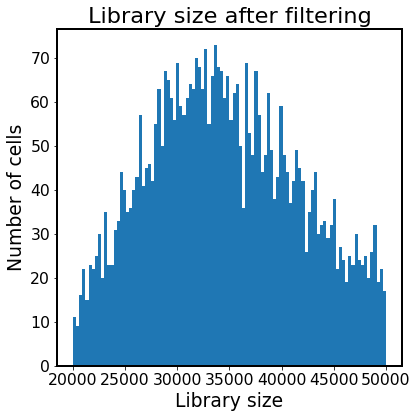

In [92]:
libcutoff = (20000,50000)
scprep.plot.plot_library_size(data, log=False, range=libcutoff, title='Library size after filtering');

In [93]:
data_filt = scprep.filter.filter_library_size(data, cutoff=libcutoff, keep_cells='between');
data_filt.shape

(4254, 36601)

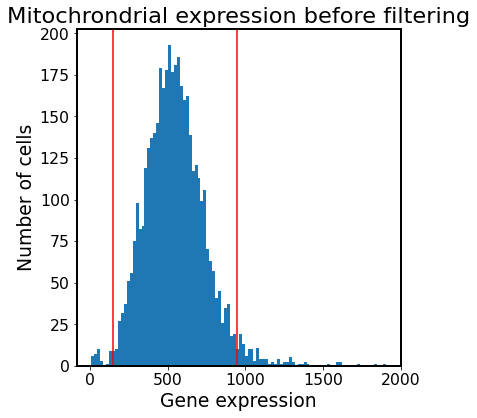

In [94]:
# Plot all mitochondrial genes. There are 14, FYI.
#mtgenes = scprep.select.get_gene_set(data, starts_with="MT-")
mtcutoff = [150,950];
scprep.plot.plot_gene_set_expression(data_filt, starts_with="MT-",
                                     library_size_normalize=True, cutoff=mtcutoff,
                                     title="Mitochrondrial expression before filtering");

In [15]:
data_filt = scprep.filter.filter_gene_set_expression(data_filt, starts_with="MT-", cutoff=mtcutoff, keep_cells='between', library_size_normalize=True)
data_filt.shape

(4095, 36601)

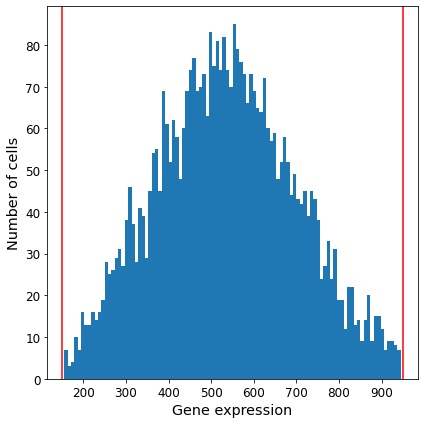

In [16]:
scprep.plot.plot_gene_set_expression(data_filt, starts_with="MT-", library_size_normalize=True, cutoff=mtcutoff);

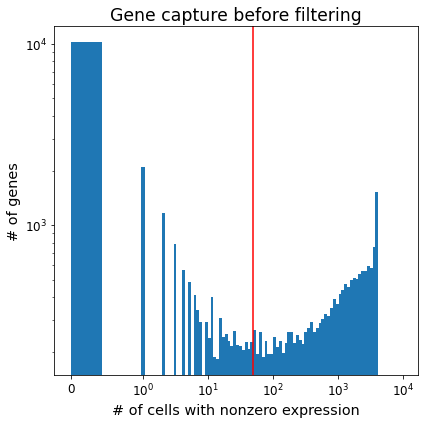

In [18]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), log=True, cutoff=50,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes');

In [20]:
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=50)
data_filt.shape

(4095, 16151)

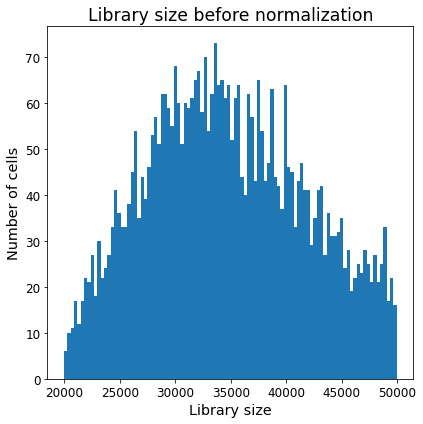

In [21]:
scprep.plot.plot_library_size(data_filt, title='Library size before normalization', log=False);

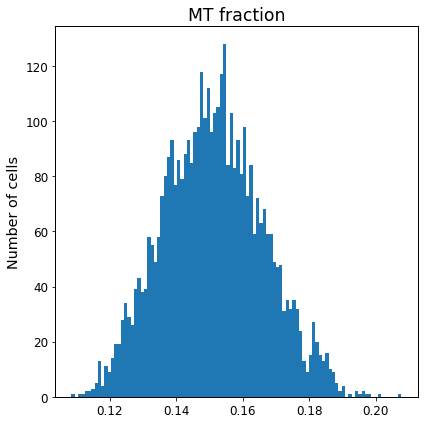

In [432]:
# check mitochondrial fraction after all filtering
mt_expr = get_genes_expression(data_filt, 'MT-')  
libsize = np.sum(data_filt, axis=1)
mt_frac = mt_expr/libsize
scprep.plot.histogram(mt_frac, title='MT fraction');

## Normalization and transformation

In [22]:
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)

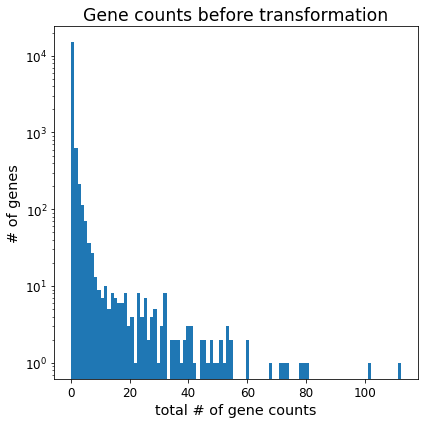

In [23]:
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes');

In [24]:
data_sqrt = scprep.transform.sqrt(data_norm)

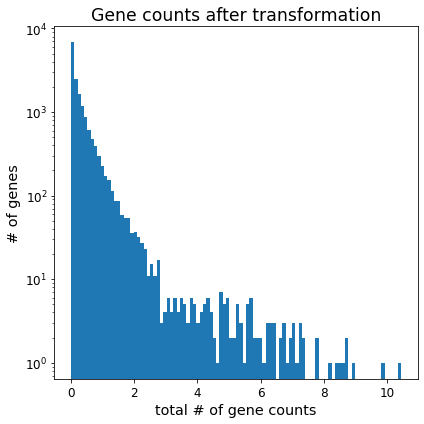

In [25]:
scprep.plot.histogram(data_sqrt.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes');

In [29]:
# SAVE PREPROCESSED DATA
os.chdir(dataDir)
data_sqrt.to_pickle("Jo_preprocessed_data_sqrt.pickle.gz")
data_filt.to_pickle("Jo_preprocessed_data_filt.pickle.gz")
library_size.to_pickle("Jo_library_size.pickle.gz")

## Load preprocessed data and run denoising

In [95]:
# LOAD PREPROCESSED DATA

os.chdir(dataDir)
data_filt  = pd.read_pickle("Jo_preprocessed_data_filt.pickle.gz")
data_sqrt = pd.read_pickle("Jo_preprocessed_data_sqrt.pickle.gz")
library_size = pd.read_pickle("Jo_library_size.pickle.gz")

In [15]:
# DENOISING
#data_sqrt_magic = magic.MAGIC().fit_transform(data_sqrt)
#data_sqrt_magic.to_csv('data_sqrt_magic.csv');
data_sqrt_magic = pd.read_csv('data_sqrt_magic.csv')

## Highly Variable Genes

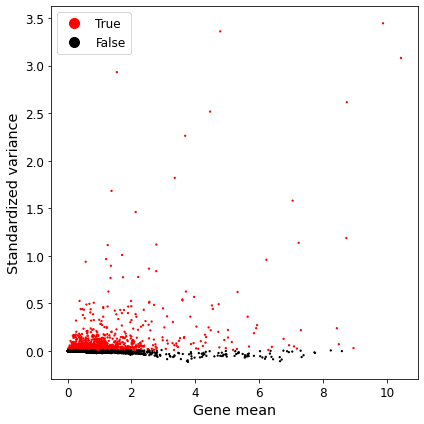

In [16]:
scprep.plot.plot_gene_variability(data_sqrt, percentile=90);

In [17]:
data_sqrt_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)

In [18]:
print(data_sqrt_hvg.shape)

(4095, 1615)


## PHATE visualization and PCA

In [19]:
# dimensionality reduction for visualization
data_sqrt_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)
data_sqrt_phate = phate.PHATE(verbose=False).fit_transform(data_sqrt_hvg)

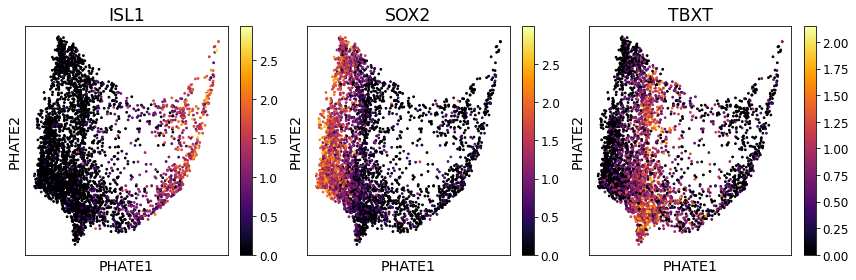

In [20]:
# inspect some marker genes
mylist = ["SOX2 ","TBXT","ISL1"]
plot_genes(data_sqrt_phate, data_sqrt, mylist)

In [21]:
data_sqrt_pca, sqrt_singular_values = scprep.reduce.pca(data_sqrt, n_components=50, method='dense', return_singular_values=True)

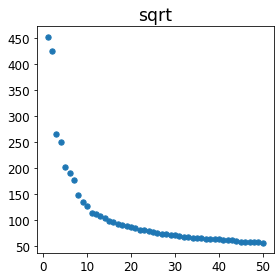

In [25]:
# it appears 2, 4, 7, or 10 components still contain real information after which we have mostly noise
npc = 50;
scprep.plot.scatter(np.arange(npc)+1,sqrt_singular_values[:npc],figsize=(4,4),title='sqrt');

## Using a manual subset of genes

In [111]:
data_sqrt_mygenes = scprep.select.select_cols(data_sqrt, regex=list(allgenes))
#data_sqrt_mygenes_phate = phate.PHATE(verbose=False).fit_transform(data_sqrt_mygenes)
#np.savetxt('data_sqrt_mygenes_phate.csv', data_sqrt_mygenes_phate, delimiter=',')
data_sqrt_mygenes_phate = np.loadtxt('data_sqrt_mygenes_phate.csv', delimiter=',')

In [105]:
data_sqrt_mygenes.shape

(4095, 188)

In [106]:
collist, genesymbolslist = select_genes(data_sqrt, allgenes)

In [110]:
# SAVE THE LIST OF GENES
df = pd.DataFrame(genesymbolslist);
array = df.to_numpy();
for i in range(0,4):
    array = np.append(array,'');
array = array.reshape(24,8)
#np.reshape(array, shape, order = 'C')
df = pd.DataFrame(array)
df.to_excel('gastrula_genes.xlsx');

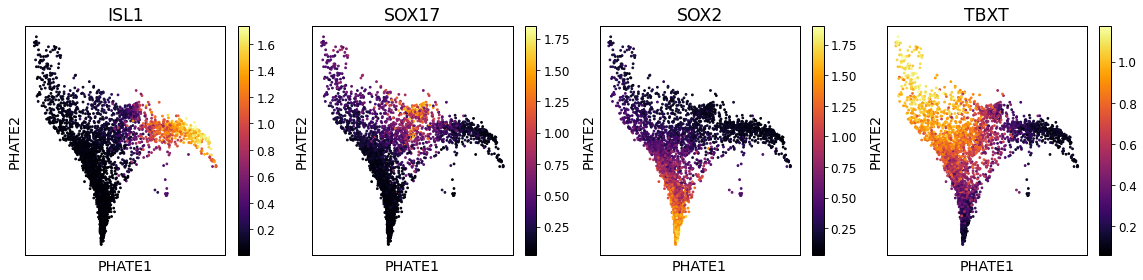

In [112]:
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 1})
plot_genes(data_sqrt_mygenes_phate, data_sqrt_magic, coremarkers)

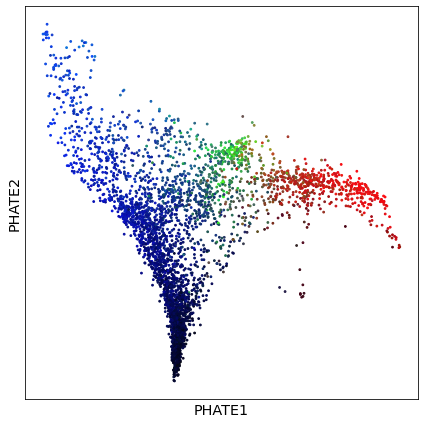

In [18]:
mymarkers = ['EOMES','ISL1','SOX17'];
selection = scprep.select.select_cols(data_sqrt_magic, exact_word=mymarkers);
selection = selection.iloc[:,[1,2,0]];
x = selection.to_numpy();
y = x/np.max(x,axis=0);
#y = np.sqrt(y);

scprep.plot.scatter2d(data_sqrt_mygenes_phate, c=y, ticks=False, label_prefix='PHATE');
plt.savefig('scRNAseq_'+"".join(mymarkers)+'_RGB.png')

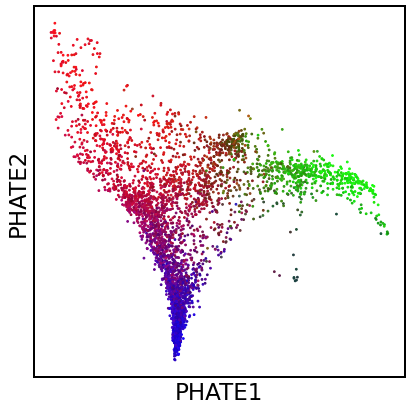

In [50]:
mymarkers = ['SOX2','TBXT','ISL1'];
selection = scprep.select.select_cols(data_sqrt_magic, exact_word=mymarkers);
selection = selection.iloc[:,[2,1,0]];
x = selection.to_numpy();
y = x/np.max(x,axis=0);
#y = np.sqrt(y);
plt.rcParams.update({'font.size':16})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})
scprep.plot.scatter2d(data_sqrt_mygenes_phate, c=y, ticks=False, label_prefix='PHATE');
plt.savefig('scRNAseq_'+"".join(mymarkers)+'_RGB.png')

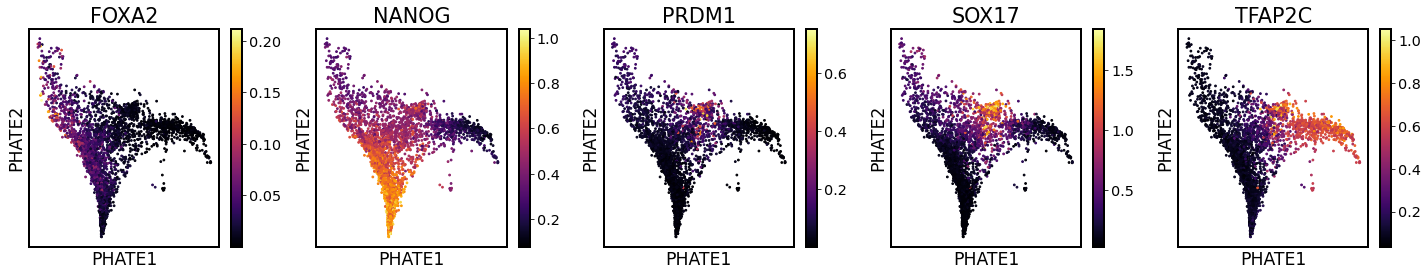

In [31]:
mymarkers=['SOX17','TFAP2C','PRDM1 ','NANOG','FOXA2'];
plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})
plot_genes(data_sqrt_mygenes_phate, data_sqrt_magic, mymarkers);
plt.savefig('scRNAseq_'+"".join(mymarkers)+'.png')

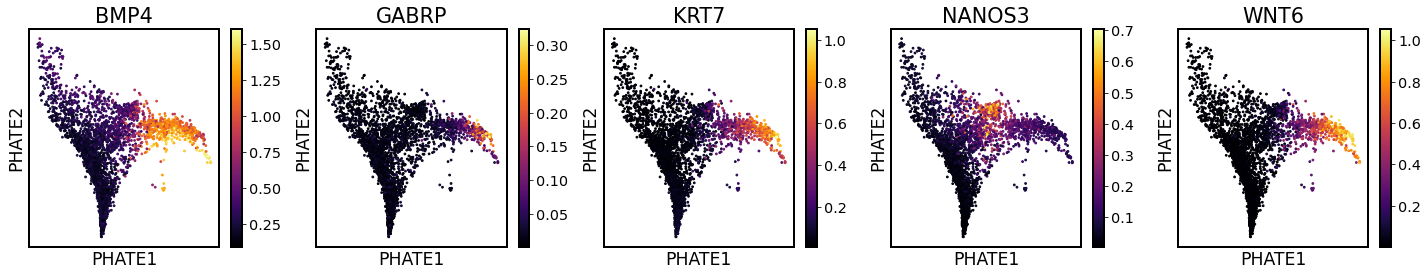

In [30]:
mymarkers=['NANOS3','BMP4 ','WNT6','GABRP','KRT7'];#'NANOS3',,'EGF ','EGFR'
plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})
plot_genes(data_sqrt_mygenes_phate, data_sqrt_magic, mymarkers);
plt.savefig('scRNAseq_'+"".join(mymarkers)+'.png')

## Scaling and diffusion maps

In [68]:
adata_sqrt = anndata.AnnData(data_sqrt)
adata_sqrt_scale = scanpy.pp.scale(adata_sqrt, copy=True)
data_sqrt_scale = pd.DataFrame(adata_sqrt_scale.X, index=data_sqrt.index, columns=data_sqrt.columns)
#data_sqrt_scale.to_csv('data_sqrt_scale.csv');

In [354]:
adata_sqrt_mygenes = anndata.AnnData(data_sqrt_mygenes)
adata_sqrt_mygenes_scale = scanpy.pp.scale(adata_sqrt_mygenes, copy=True)
data_sqrt_mygenes_scale = pd.DataFrame(adata_sqrt_mygenes_scale.X, index=data_sqrt_mygenes.index, columns=data_sqrt_mygenes.columns)
#data_sqrt_mygenes_scale.to_csv('data_sqrt_mygenes_scale.csv');

In [334]:
collist,__ = select_genes(data_sqrt_mygenes,['SOX2','ISL1','SOX17','TBXT','HMGA1','FOXA2', 'MESP1', 'PDGFRA'])

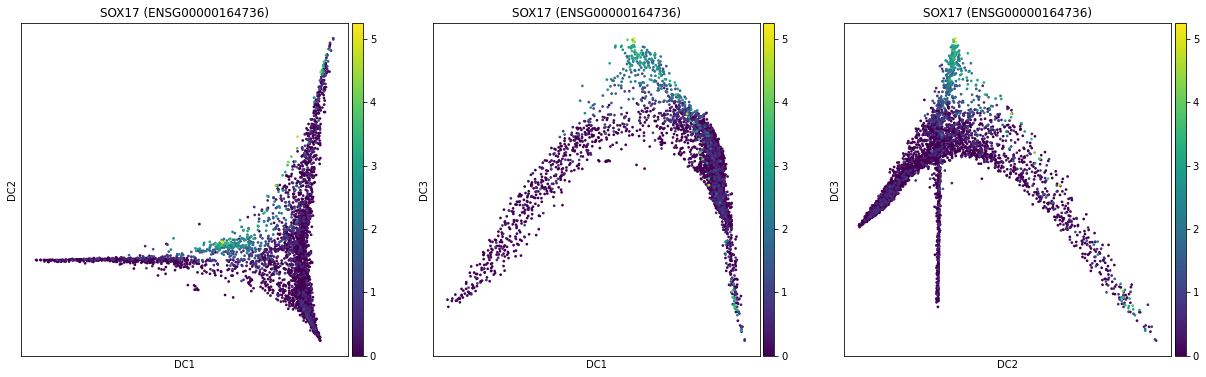

In [335]:
#scanpy.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
#scanpy.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
scanpy.pp.neighbors(adata_sqrt_mygenes)
scanpy.tl.diffmap(adata_sqrt_mygenes)
scanpy.pl.diffmap(adata_sqrt_mygenes,color=collist[2], components=['1,2','1,3','2,3'])

In [336]:
plt.savefig('scRNAseq_diffmap_SOX17.png');

<Figure size 432x432 with 0 Axes>

         Falling back to preprocessing with `sc.pp.pca` and default params.


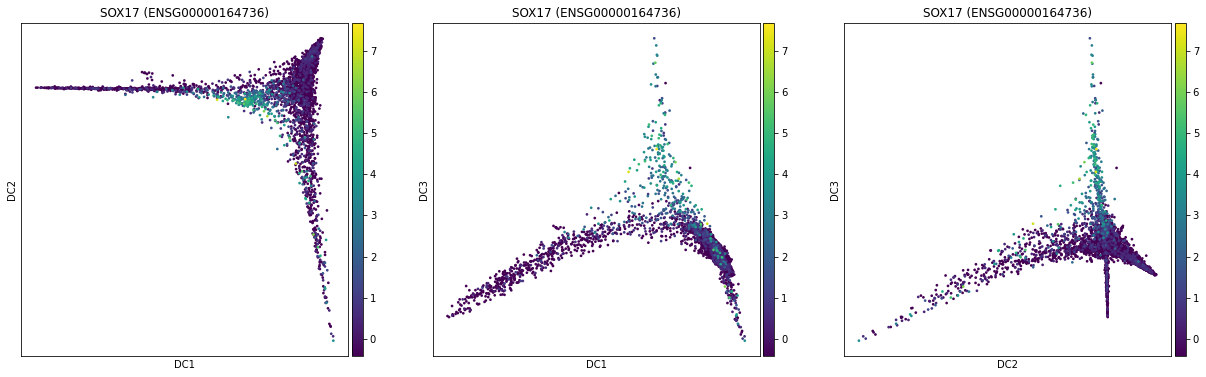

In [47]:
scanpy.pp.neighbors(adata_sqrt_mygenes_scale)
scanpy.tl.diffmap(adata_sqrt_mygenes_scale)
scanpy.pl.diffmap(adata_sqrt_mygenes_scale,color=collist[2], components=['1,2','1,3','2,3'])

In [49]:
plt.savefig('scRNAseq_diffmap_scaled_SOX17.png');

<Figure size 432x432 with 0 Axes>

## Clustering

0.08388489119651038

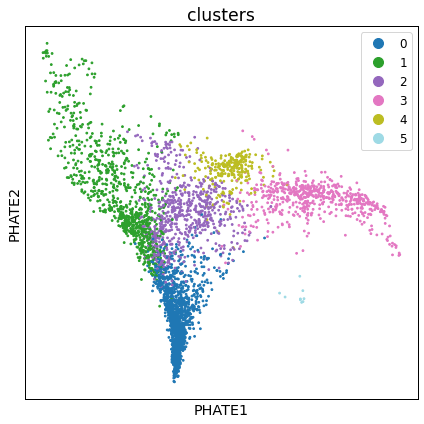

In [122]:
data_pca = scprep.reduce.pca(data_sqrt_mygenes, n_components=50, method='dense')    
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()
partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                   weights="weight", resolution_parameter=0.5)
louvain_clusters = np.array(partition.membership)

scprep.plot.scatter2d(data_sqrt_mygenes_phate, c=louvain_clusters, cmap=plt.cm.tab20, 
                        title='clusters', 
                        ticks=False, legend=True, discrete=True, label_prefix='PHATE');
sklearn.metrics.silhouette_score(data_sqrt_mygenes.to_numpy(), louvain_clusters)

In [75]:
# SAVE louvain_clusters
#np.savetxt('louvain_clusters.csv', louvain_clusters, delimiter=',')
louvain_clusters = np.loadtxt('louvain_clusters.csv', delimiter=',')

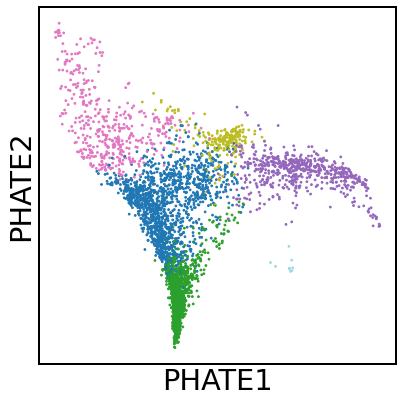

In [165]:
plt.rcParams.update({'font.size':20})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})

scprep.plot.scatter2d(data_sqrt_mygenes_phate, c=louvain_clusters, cmap=plt.cm.tab20, 
                        ticks=False, legend=False, discrete=True, label_prefix='PHATE');
plt.savefig('louvain_clusters.png')

## Marker genes

[35.55555556 33.38217338 14.82295482 10.74481074  5.27472527  0.21978022]


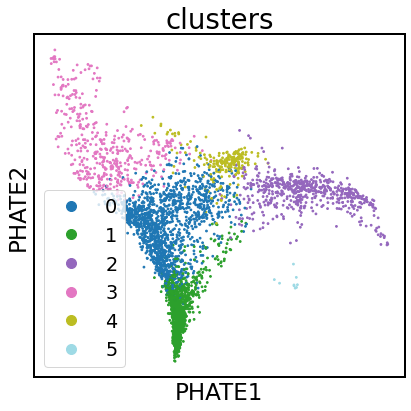

In [145]:
n_clusters = 6
scprep.plot.scatter2d(data_sqrt_mygenes_phate, c=louvain_clusters, cmap=plt.cm.tab20, 
                        title='clusters', 
                        ticks=False, legend=True, discrete=True, label_prefix='PHATE');
[a,bins] = np.histogram(louvain_clusters,bins=n_clusters);
print(100*a/np.sum(a))

In [40]:
np.sum(clusters==5)

9

In [73]:
clusterlabels = ['iMeLC','pluri','AMLC','PS','PGC','ExMe']

In [69]:
sqrt_scale_mean_diff_results = scprep.stats.differential_expression_by_cluster(data_sqrt_scale, louvain_clusters, n_jobs=-1, direction='up')
sqrt_scale_emd_results = scprep.stats.differential_expression_by_cluster(data_sqrt_scale, louvain_clusters, measure='emd', n_jobs=-1, direction='up')
sqrt_scale_ttest_results = scprep.stats.differential_expression_by_cluster(data_sqrt_scale, louvain_clusters, measure='ttest',n_jobs=-1, direction='up')

In [423]:
clustermarkers_dict = dict();
for i  in range(0,6) : 
    clustermarkers_dict[i] = pd.DataFrame(sqrt_scale_emd_results[i].index[0:20],columns=[clusterlabels[i]]);#pd.DataFrame;
clustermarkers = pd.concat(clustermarkers_dict.values(),axis=1)
#clustermarkers.to_csv(dataDir+'clustermarkers.csv')
for col in clustermarkers.columns :
    clustermarkers[col] = clustermarkers[col].str.split(expand=True)[0]
clustermarkers.to_excel(dataDir+'clustermarkers.xlsx')
pd.set_option('display.max_rows', None)
clustermarkers

,iMeLC,pluri,AMLC,PS,PGC,ExMe
0,MIXL1,SOX2,ISL1,GATA6,SOX17,SERPINE1
1,SERPINE2,TERF1,CLDN10,MESP1,PRDM1,NPPB
2,GAL,ESRG,AMER2,CER1,NANOS3,ANXA1
3,MEIS3,LNCPRESS1,SGK1,FGF17,CRHBP,SPP1
4,CNTNAP2,USP44,KRT19,GATA6-AS1,TFAP2C,MYL7
5,EOMES,POLR3G,HPGD,DKK1,AC007326.5,TAGLN
6,CYP1B1,FOXD3-AS1,HAPLN1,MIXL1,LBH,VIM
7,WNT3,DPPA4,KRT8,MESP2,GLIPR2,ACTA1
8,PCDH10,PLAAT3,BAMBI,LZTS1,TMEM64,FLNC
9,TBXT,AASS,TMEM54,CDH2,PCAT14,ANKRD1


In [404]:
clustermarkers_dict = dict();
for i  in range(0,6) : 
    clustermarkers_dict[i] = pd.DataFrame(sqrt_scale_emd_results[i].index[0:10]);#pd.DataFrame;
clustermarkersflat = pd.concat(clustermarkers_dict.values(),axis=0)
clustermarkersflat

,0
0,MIXL1 (ENSG00000185155)
1,SERPINE2 (ENSG00000135919)
2,GAL (ENSG00000069482)
3,MEIS3 (ENSG00000105419)
4,CNTNAP2 (ENSG00000174469)
5,EOMES (ENSG00000163508)
6,CYP1B1 (ENSG00000138061)
7,WNT3 (ENSG00000108379)
8,PCDH10 (ENSG00000138650)
9,TBXT (ENSG00000164458)


In [424]:
sqrt_mygenes_scale_emd_results = scprep.stats.differential_expression_by_cluster(data_sqrt_mygenes_scale, louvain_clusters, measure='emd', n_jobs=-1, direction='up')
clustermarkers_dict = dict();
for i  in range(0,6) : 
    clustermarkers_dict[i] = pd.DataFrame(sqrt_mygenes_scale_emd_results[i].index[0:20],columns=[clusterlabels[i]]);#pd.DataFrame;
clustermarkers_mygenes = pd.concat(clustermarkers_dict.values(),axis=1)
for col in clustermarkers_mygenes.columns :
    clustermarkers_mygenes[col] = clustermarkers_mygenes[col].str.split(expand=True)[0]
clustermarkers_mygenes.to_excel(dataDir+'clustermarkers_mygenes.xlsx')
clustermarkers_mygenes

,iMeLC,pluri,AMLC,PS,PGC,ExMe
0,MIXL1,SOX2,ISL1,GATA6,SOX17,VIM
1,EOMES,ESRG,HAND1,MESP1,PRDM1,POSTN
2,WNT3,DPPA4,WNT6,CER1,NANOS3,COL1A1
3,TBXT,PEBP1,GATA3,FGF17,TFAP2C,SOX3
4,NODAL,TDGF1,BMP4,DKK1,TFAP2A,NES
5,FGF4,LEFTY1,DLX5,MIXL1,WNT5B,DUSP8
6,FGF8,NANOG,KRT18,CDH2,TBX3,PODXL
7,CDH2,PODXL,TFAP2A,LHX1,CXCR4,NOG
8,IL17RD,SPRY1,TBX3,GSC,GATA3,FZD2
9,DUSP5,FZD5,EPCAM,RSPO3,VIM,NKX2-5


In [400]:
clustermarkers_dict = dict();
for i  in range(0,6) : 
    clustermarkers_dict[i] = pd.DataFrame(sqrt_mygenes_scale_emd_results[i].index[0:10]);#pd.DataFrame;
clustermarkers_mygenesflat = pd.concat(clustermarkers_dict.values(),axis=0)
clustermarkers_mygenesflat

,0
0,MIXL1 (ENSG00000185155)
1,EOMES (ENSG00000163508)
2,WNT3 (ENSG00000108379)
3,TBXT (ENSG00000164458)
4,NODAL (ENSG00000156574)
5,FGF4 (ENSG00000075388)
6,FGF8 (ENSG00000107831)
7,CDH2 (ENSG00000170558)
8,IL17RD (ENSG00000144730)
9,FLRT2 (ENSG00000185070)


## Heatmap

In [78]:
# z-score all data
data_sqrt_zscore = sklearn.preprocessing.StandardScaler().fit_transform(data_sqrt.to_numpy())

In [79]:
clusters = louvain_clusters;
Nclusters = int(np.max(clusters+1))
Ngenes = data_filt.shape[1]
cluster_means = np.zeros((Nclusters, Ngenes))
cluster_means_zscore = np.zeros((Nclusters, Ngenes))

for i in range(0, Nclusters) :
    cluster_means[i,:] = np.mean(data_sqrt.iloc[clusters==i,:],axis=0)
    cluster_means_zscore[i,:] = np.mean(data_sqrt_zscore[clusters==i,:],axis=0)

In [80]:
cluster_means = pd.DataFrame(cluster_means, columns=data_sqrt.columns, index=clusterlabels)
cluster_means_zscore = pd.DataFrame(cluster_means_zscore, columns=data_sqrt.columns, index=clusterlabels)

In [38]:
cluster_means_zscore.to_csv(dataDir+'cluster_means_zscore.csv');
cluster_means.to_csv(dataDir+'cluster_means.csv');

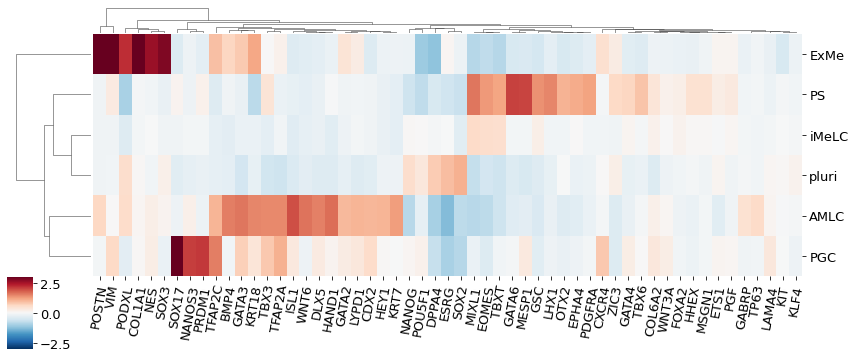

In [81]:
plt.rcParams.update({'font.size':13})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

cols, symbols = select_genes(data_sqrt, germmarkers) # germmarkers
g = sb.clustermap(cluster_means_zscore[cols], xticklabels=symbols,vmax=3,vmin=-3,dendrogram_ratio=0.1,figsize=(12,5),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig('clustermap_germmarkers_louvain.png', bbox_inches='tight');

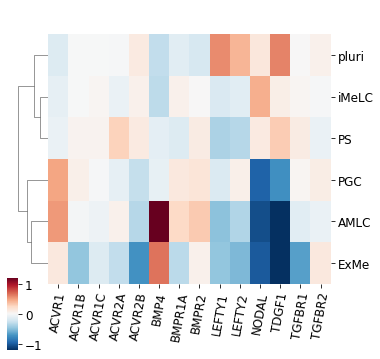

In [224]:
mymarkers=['ACVR[1-2][ABC]*($| )','TGFBR1','TGFBR2','TDGF','BMPR','LEFTY','NODAL','BMP4'];#,'FST', 'INHB']
plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

cols, symbols = select_genes(data_sqrt, mymarkers) # germmarkers
g = sb.clustermap(cluster_means_zscore[cols], xticklabels=symbols,dendrogram_ratio=0.1,vmin=-1.2,vmax=1.2,figsize=(5,5),cbar_pos=(0.01,0.01,0.03,0.2),col_cluster=False,cmap='RdBu_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig('clustermap_NodalRegulation_louvain2.png', bbox_inches='tight');

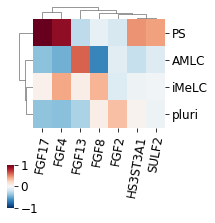

In [239]:
FGFR = ['FGFR[1-4]($| )']
extracell_FGFact = ['KL($| )','GLG1($| )','FLRT($| )', 'KAL1($| )'] # klotho, cfr, flrt, anosmin-1
extracell_FGFinh = ['FGFRL1','IL17RD'] # FGFRL1, SEF
intracell_ERKinh = ['SPRY[1-4]($| )','DUSP[1-9]($| )','DUSP10($| )','DUSP14($| )','DUSP26($| )','PEBP1($| )']
intracell_ERKact = ['MAP2K[1-2]($| )','MAPK3($| )','MAPK1($| )','ARAF($| )','BRAF($| )','RAF1($| )'] #K3 = ERK1, #K1 = ERK2, MEK1/2 are phosporylated by RAS
HSPG_synthesis = ['EXT1($| )','EXT2($| )','UGDH($| )'] # EXT catalyze HS side chain elongation, UGDH : Garcia-Garcia & Anderson, makes side chains
HSPG = ['HSPG2($| )', 'AGRIN($| )', 'SDC[1-4]($| )', 'GPC[1-9]($| )'] # HSPG2: perlecan (secreted), agrin=secreted, syndecan=transmembrane, glypican (GPI-anchored)
HSPG_desulf = ['SULF'] # 6-O sulfatases - inhibit FGF
HSPG_shedding = ['HPSE($| )', 'htra1($| )'] # heparanase
HSPG_sulfotransferase = ['HS6ST','HS2ST', 'HS3ST', 'NDST'] 

#mymarkers = HSPG_desulf + HSPG_sulfotransferase + ['FGF[1-9]+ ']
mymarkers = ['SULF2','HS3ST3A', 'FGF4','FGF17','FGF13 ','FGF8','FGF2 ']
plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

cluster_means_zscore_x = cluster_means_zscore;
cluster_means_zscore_x = cluster_means_zscore_x.iloc[[0,1,2,3]]; # exclude exmeso
cols, symbols = select_genes(data_sqrt, mymarkers) # germmarkers
g = sb.clustermap(cluster_means_zscore_x[cols], xticklabels=symbols,vmax=1,vmin=-1,dendrogram_ratio=0.1,figsize=(3,3),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig('clustermap_FGFRegulation_louvain.png', bbox_inches='tight');

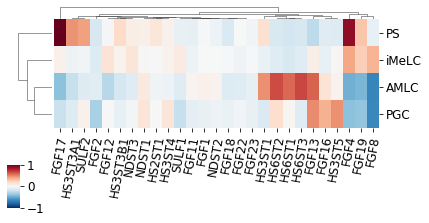

In [220]:
FGFR = ['FGFR[1-4]($| )']
extracell_FGFact = ['KL($| )','GLG1($| )','FLRT($| )', 'KAL1($| )'] # klotho, cfr, flrt, anosmin-1
extracell_FGFinh = ['FGFRL1','IL17RD'] # FGFRL1, SEF
intracell_ERKinh = ['SPRY[1-4]($| )','DUSP[1-9]($| )','DUSP10($| )','DUSP14($| )','DUSP26($| )','PEBP1($| )']
intracell_ERKact = ['MAP2K[1-2]($| )','MAPK3($| )','MAPK1($| )','ARAF($| )','BRAF($| )','RAF1($| )'] #K3 = ERK1, #K1 = ERK2, MEK1/2 are phosporylated by RAS
HSPG_synthesis = ['EXT1($| )','EXT2($| )','UGDH($| )'] # EXT catalyze HS side chain elongation, UGDH : Garcia-Garcia & Anderson, makes side chains
HSPG = ['HSPG2($| )', 'AGRIN($| )', 'SDC[1-4]($| )', 'GPC[1-9]($| )'] # HSPG2: perlecan (secreted), agrin=secreted, syndecan=transmembrane, glypican (GPI-anchored)
HSPG_desulf = ['SULF'] # 6-O sulfatases - inhibit FGF
HSPG_shedding = ['HPSE($| )', 'htra1($| )'] # heparanase
HSPG_sulfotransferase = ['HS6ST','HS2ST', 'HS3ST', 'NDST'] 

mymarkers = HSPG_desulf + HSPG_sulfotransferase + ['FGF[1-9]+ ']
#mymarkers = ['SULF2','HS3ST3A', 'FGF4','FGF17','FGF13 ','FGF8','FGF2 ']
plt.rcParams.update({'font.size':12})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

cluster_means_zscore_x = cluster_means_zscore;
cluster_means_zscore_x = cluster_means_zscore_x.iloc[[0,2,3,4]]; # exclude exmeso
cols, symbols = select_genes(data_sqrt, mymarkers) # germmarkers
g = sb.clustermap(cluster_means_zscore_x[cols], xticklabels=symbols,vmax=1,vmin=-1,dendrogram_ratio=0.1,figsize=(6,3),cbar_pos=(0.01,0.01,0.03,0.2),cmap='RdBu_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig('clustermap_FGFRegulation_louvainMore.png', bbox_inches='tight');

## Gene relationships

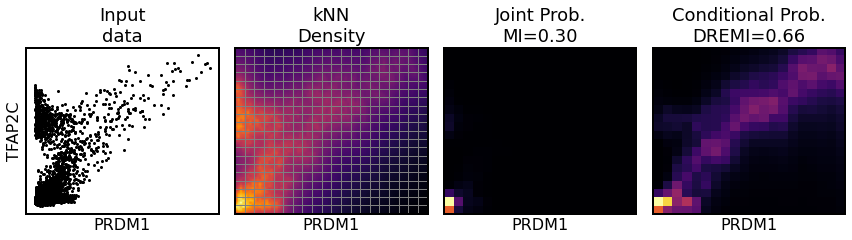

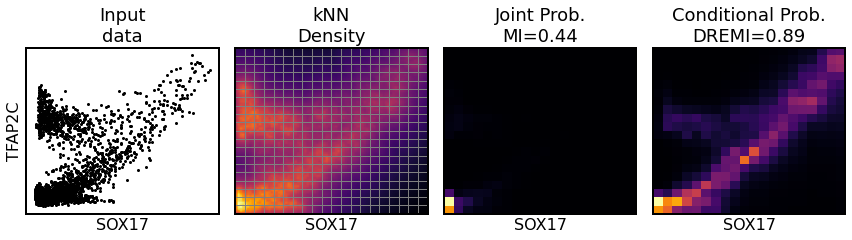

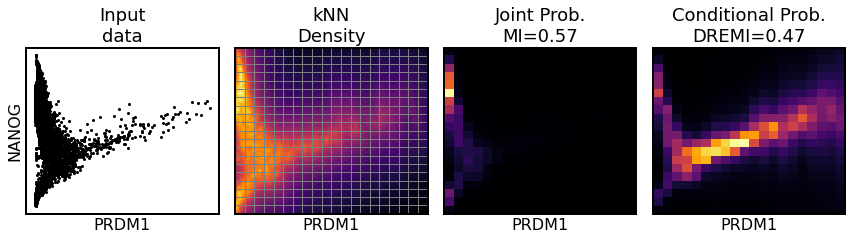

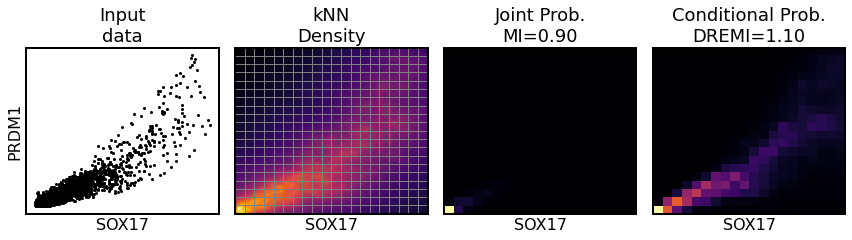

In [327]:
pairs = [['PRDM1','TFAP2C'],['SOX17','TFAP2C'],['PRDM1','NANOG'],['SOX17','PRDM1']];

for p in pairs:
    gene_x = p[0];
    gene_y = p[1];
    X = scprep.select.select_cols(data_sqrt_magic, exact_word=[gene_x]);
    Y = scprep.select.select_cols(data_sqrt_magic, exact_word=[gene_y]);
    scprep.stats.knnDREMI(X, Y, xlabel=gene_x, ylabel=gene_y, plot=True)

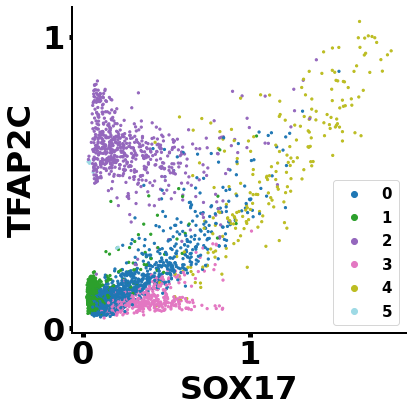

In [341]:
p = pairs[1]
X = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[0]]);
Y = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[1]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=louvain_clusters,s=5, cmap=plt.cm.tab20)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right",fontsize=15) #, title="Classes",

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'_clusters.png', bbox_inches='tight');

In [352]:
plt.cm.tab20(20)

(0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)

In [329]:
dfY = pd.DataFrame(Y);
dfC = pd.DataFrame(louvain_clusters,columns=['cluster']);

df = dfY.merge(X,left_index=True,right_index=True) 
df = df.merge(dfC,left_index=True,right_index=True) 
df.to_csv('scRNAseq_'+p[0]+'_'+p[1]+'_clusters.csv');

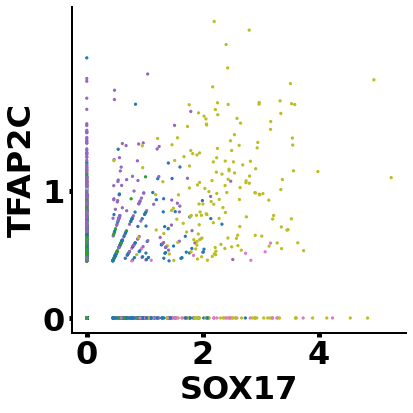

In [46]:
p = pairs[1]
X = scprep.select.select_cols(data_sqrt, exact_word=[p[0]]);
Y = scprep.select.select_cols(data_sqrt, exact_word=[p[1]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=louvain_clusters,s=5, cmap=plt.cm.tab20)
#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="lower right",fontsize=15) #, title="Classes",

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'_nomagic_clusters.png', bbox_inches='tight');

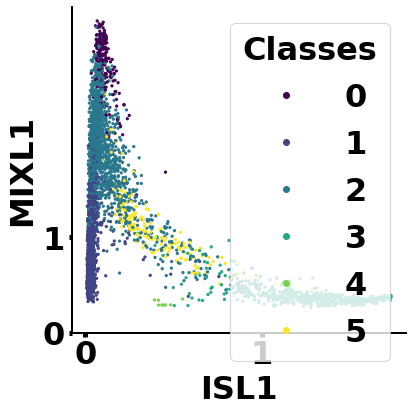

In [330]:
p = ['ISL1','MIXL1']
X = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[0]]);
Y = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[1]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=spectral_clusters_sqrt_mygenes_scale[6],s=5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

ax.set_xlabel(p[0]);
ax.set_ylabel(p[1]);

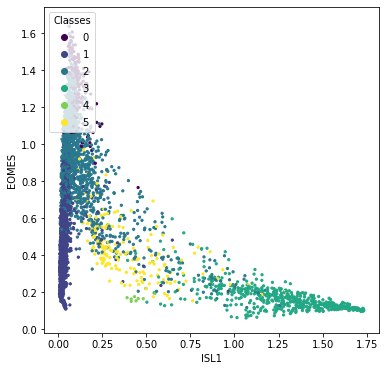

In [243]:
p = ['ISL1','EOMES']
X = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[0]]);
Y = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[1]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=spectral_clusters_sqrt_mygenes_scale[6],s=5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")

ax.set_xlabel(p[0]);
ax.set_ylabel(p[1]);
plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'.png');

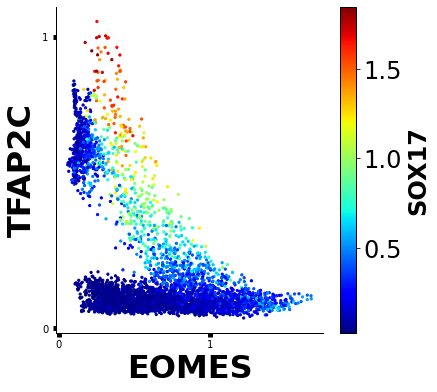

In [62]:
p = ['EOMES','TFAP2C','SOX17']
d = data_sqrt_magic;
X = scprep.select.select_cols(d, exact_word=[p[0]]);
Y = scprep.select.select_cols(d, exact_word=[p[1]]);
Z = scprep.select.select_cols(d, exact_word=[p[2]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=Z,s=5,cmap='jet')

from matplotlib.cm import ScalarMappable
scales = Z;
cmap = plt.get_cmap("jet")
norm = plt.Normalize(scales.min(), scales.max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=24)
cbar.set_label(label=p[2],weight='bold',size=24)

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

#plt.box(on=None)
plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'_'+p[2]+'.png', bbox_inches='tight');

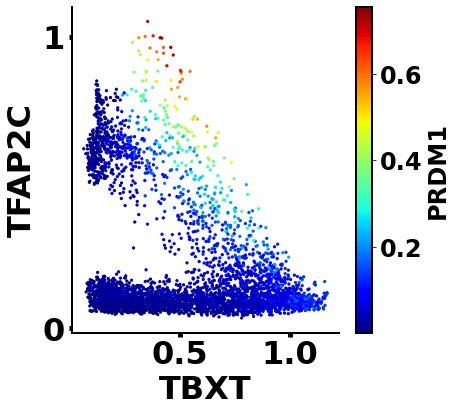

In [328]:
p = ['TBXT','TFAP2C','PRDM1']
d = data_sqrt_magic;
X = scprep.select.select_cols(d, exact_word=[p[0]]);
Y = scprep.select.select_cols(d, exact_word=[p[1]]);
Z = scprep.select.select_cols(d, exact_word=[p[2]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=Z,s=5,cmap='jet')

from matplotlib.cm import ScalarMappable
scales = Z;
cmap = plt.get_cmap("jet")
norm = plt.Normalize(scales.min(), scales.max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=24)
cbar.set_label(label=p[2],weight='bold',size=24)

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

#plt.box(on=None)
plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'_'+p[2]+'.png', bbox_inches='tight');

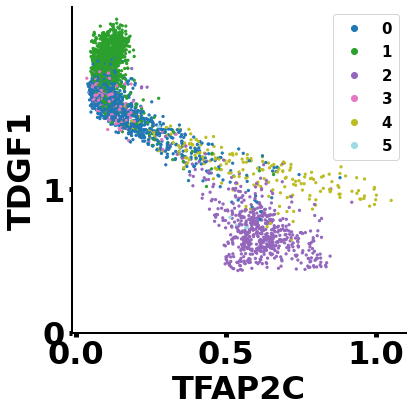

In [128]:
p = ['TFAP2C','TDGF1']
#p = ['NODAL','LEFTY2']
#p = ['NANOS3','TDGF1']
X = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[0]]);
Y = scprep.select.select_cols(data_sqrt_magic, exact_word=[p[1]]);

fig, ax = plt.subplots()
scatter = ax.scatter(X,Y,c=louvain_clusters,s=5, cmap=plt.cm.tab20)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right",fontsize=15) #, title="Classes",

fontsize = 32;
plt.rcParams.update({'font.size':fontsize})
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams.update({'axes.linewidth': 2})
ax.set_xlabel(p[0],fontsize=fontsize,fontweight='bold');
ax.set_ylabel(p[1],fontsize=fontsize,fontweight='bold');
ax.set_yticks([0, 1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

plt.savefig('scRNAseq_'+p[0]+'_'+p[1]+'_clusters.png', bbox_inches='tight');